# NN Regression House Price California

## Imports

In [459]:
import numpy as np
#Serelizar y deserializar objetos Python
import pickle
#Dataset 
from sklearn.datasets import fetch_openml
#Paths
import os.path

## Framework

### Functions

In [460]:
"""
Definición de funciones de activación, derivadas 
"""
def sigmoid(x):
    return 1.0/(1.0+np.exp(-x))

def sigmoid_grad(sigmoid):
    """
    NOTA: Observe que recibe el sigmoid ya calculado
    """
    return sigmoid * (1.0 - sigmoid)

def relu(x):
    return x * (x > 0)

def relu_grad(x):
    return 1.0 * (x > 0)

def softmax(x):
    exp_x = np.exp(x)
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

# def logloss (x, y):
#     probs = softmax(x)
#     return probs, y * np.log(probs)* -1

def batch_hits(x, y):
    """ Aciertos """
    return np.sum(np.argmax(x, axis=1) == y)

def tanh(x):
    return np.tanh(x)

def tanh_derivative(x):
    return 1 - np.tanh(x) ** 2

### Base

In [461]:
class base():
    """ Codigo de clase base para crear una capa
        Cada capa debe de implementar su método de forward y backward
        Además debe de almacenar el calculo de self.grads
    """
    def __init__(self, input_size, output_size, use_xavier = True) -> None:
        self.input_size = input_size
        self.output_size = output_size
        if use_xavier:
            self._xavier_initialization() 
        else:
            self._initialization_uniform()
        self.o = np.zeros(output_size)
        self.x = None # Asignado durante el forward

    def _initialization_uniform(self):
        self.W = np.random.randn(self.input_size, self.output_size)
        self.b = np.random.randn(self.output_size)
        
    def _xavier_initialization(self):
        """
        Understanding the difficulty of training deep feedforward neural networks
        Xavier Glorot, Yoshua Bengio
        """
        self.W = np.random.randn(self.input_size, self.output_size) / np.sqrt(self.input_size)
        self.b = np.random.randn(self.output_size)
        # limit = np.sqrt(6 / (self.input_size + self.output_size))
        # self.W = np.random.uniform(-limit, limit, size=(self.input_size, self.output_size))
        # self.b = np.zeros((1, self.output_size))  # siempre puedes iniciar biases en cero
    
    def forward(self, x):
        pass
    
    def backward(self, prev):
        pass

    def update(self, lr):
        self.W -= lr * np.dot(self.x.T, self.grads)#
        self.b -= lr * np.mean(self.grads, axis = 0)


### Loss Layer

In [462]:
class loss_layer(base):
    """
    Capa de perdida:
    Implementa la clase base, utiliza la función de perdida softmax 
    """
    def __init__(self, input_size, output_size) -> None:
        super().__init__(input_size, output_size)
        self.grads = np.zeros((output_size, input_size))

    def forward(self, x):
        self.x = x
        self.output = np.dot(x, self.W) + self.b
        # print(f"forward loss_layer.output.shape: {self.output.shape}")
        return self.output
    
    def backward(self, y):
        #Calculo de gradientes
        
        # print(f"back loss_layer.output.shape: {self.output.shape}")
        # print(f"back loss_layer.y.shape: {y.shape}")
        self.grads = self.output - y
        # print(f"back loss_layer.grads.shape: {self.grads.shape}")
        # y_reshaped = y.reshape(-1, 1)
        # self.grads = self.output - y_reshaped
    
    def loss(self, y):
        return np.mean((self.output - y) ** 2)
        

### Dense Layer

In [463]:
class dense(base):
    """
    Dense o FullyConnected 
    Recibe tamaños de entrada y salida, mas la funcion de activacion y su derivada.
    """
    def __init__(self, input_size, output_size, func_acivation, func_acivation_grad):
        super().__init__(input_size, output_size)
        self.grads = np.zeros((output_size, input_size))
        self.func_activation = func_acivation
        self.func_acivation_grad = func_acivation_grad
        
    def forward(self, x):
        self.x = x
        self.linear = np.dot(x, self.W) + self.b
        self.o = self.func_activation(self.linear)
        return self.o 

    def backward(self, prev):
          # al-2 < al-1 < al.x
        # al = prev = sigmoid(x)
        # self.grads = np.dot(prev.grads, prev.W.T) * self.func_acivation_grad(prev.x)
        # print("--- Backward Debug Info ---")
        # print(f"prev.x.shape: {prev.x.shape}")
        # print(f"prev.grads.shape: {prev.grads.shape}")
        # print(f"prev.W.shape: {prev.W.shape}")
        # print(f"self.func_acivation_grad(self.x).shape: {self.func_acivation_grad(self.x).shape}")

        # self.grads = self.func_acivation_grad(prev.x) * np.dot(prev.grads, prev.W.T)
        # Corrected gradient calculation
        self.grads = np.dot(prev.grads, prev.W.T) * self.func_acivation_grad(self.o)

        # print(f"self.grads.shape: {self.grads.shape}")
        # print("--- End Backward Debug Info ---")

## Model

In [464]:
class model():
    """
    Representa todo el modelo, el tamaño de entrada  y salida de la red,
    una lista con el tamaño que debe llevar cada capa oculpa, y las funciones de activación
    y gradiente que van a tener todas las capas ocultas
    NOTA: Todas las capas ocultas tienen la misma funcion. 
    """
    def __init__(self, input_size, output_size, hidden_shapes, func_acti, func_acti_grad):
        assert(len(hidden_shapes) > 0), "Debe tener al menos 1 capa oculta"
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_shapes = hidden_shapes
        self.hidden_amount = len(self.hidden_shapes)
        self.hidden_layers = [] #Bucket de capas ocultas
        self._populate_layers(func_acti, func_acti_grad)

    def _populate_layers(self, func_acti, func_acti_grad):
        """
        Crea todas las capas ocultas de acuerdo al input size y hidden_shapes
        Agrega una capa final de perdida
        """
        input_size = self.input_size
        for i in range(0, self.hidden_amount):
            new_dense_layer = dense(input_size, self.hidden_shapes[i], func_acti, func_acti_grad)
            self.hidden_layers.append(new_dense_layer)
            input_size = self.hidden_shapes[i]

        self.loss_layer = loss_layer(input_size, self.output_size)

    def forward(self,x, y):
        """ Propaga las entradas a traves de la red 
        Returna las probabilidades y la perdida"""
        data = x
        for i in range(0, self.hidden_amount):
            data = self.hidden_layers[i].forward(data)
        
        self.o = self.loss_layer.forward(data)
        loss = self.loss_layer.loss(y)
        
        return self.o, loss
    
    def predict(self, x):
        """ Propaga las entradas a traves de la red 
        Returna las probabilidades"""
        data = x
        for i in range(0, self.hidden_amount):
            data = self.hidden_layers[i].forward(data)
        
        return self.loss_layer.forward(data)
    
    def backward(self, y, o):
        #Calcula la gradiente de la perdida con respecto a la etiqueta Y
        self.loss_layer.backward(y)
        prev = self.loss_layer
        
        for i in reversed(range(self.hidden_amount)):
            #Propaga la capa para el calculo de gradientes en cada una
            self.hidden_layers[i].backward(prev)
            prev = self.hidden_layers[i]

    def update(self, lr):
        """ Ejecuta la actualización de parametros para cada capa
            despues de actualizar los gradientes
        """
        for i in range(self.hidden_amount):
            self.hidden_layers[i].update(lr)
        self.loss_layer.update(lr)

## Dataset

In [465]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import pickle

# 1. Cargar datos
housing = fetch_california_housing()
# 3. Guardar para simular la carga como en MNIST
with open("california.ds", "wb") as f:
    pickle.dump(housing, f)

In [466]:
def _shuffle(x, y):
    assert(len(x) == len(y)), "Make sure data and labels have the same lenght!"
    rand_indexes = np.random.permutation(len(x))
    return x[rand_indexes], y[rand_indexes]

#represents a dataset, useful for val dataset, train dataset and test dataset.
class dataset():
    def __init__(self, x, y, batch_size):
        #assert(len(y) % batch_size == 0), "Make sure batch size divides number of items perfectly!"
        self.compl_x = x[:]
        self.compl_y = y[:]
        self.batch_size = batch_size
        self.reset()
        self.size = len(self.compl_y)

    def shapes(self):
        return ( self.compl_x.shape, self.compl_y.shape )

    def view(self):
        print(self.compl_x, self.compl_y)

    #iterate over the dataset
    def next(self):
        if self.left_items < self.batch_size:
            x = self.x[self.current:]
            y = self.y[self.current:]
            self.current += len(self.x)
            self.left_items = 0
            return x, y
        else:
            x = self.x[self.current:self.current+self.batch_size]
            y = self.y[self.current:self.current+self.batch_size]
            self.current += self.batch_size
            self.left_items -= self.batch_size
            return x, y

    def iter_done(self):
        return self.left_items == 0

    def reset(self):
        self.x = self.compl_x[:]
        self.y = self.compl_y[:]
        self.x, self.y = _shuffle(self.x, self.y)
        self.current = 0
        self.left_items = len(self.compl_y)

#splits a complete dataset into 3 subsets for train, val and test, by percentage
class dataset_splitter():
    def __init__(self, x, y, batch_size, perc_train=0.8, perc_val=0.2):
        self.x = x
        self.y = y
        self.split(batch_size, perc_train, perc_val)

    def _split_by_limits(self, batch_size, train_limit, val_limit):
        #Crea los dataset de entrenamiento, validación y testing
        self.ds_train = dataset(self.x[:train_limit], self.y[:train_limit], batch_size)
        self.ds_train.reset()
        self.ds_val = dataset(self.x[train_limit:val_limit], self.y[train_limit:val_limit], batch_size)
        self.ds_val.reset()
        self.ds_test = dataset(self.x[val_limit:], self.y[val_limit:], batch_size)
        self.ds_test.reset()

    def split(self, batch_size, perc_train, perc_val):
        self.x, self.y = _shuffle(self.x, self.y)
        n = len(self.x)
        train_limit = int(n * perc_train)
        temp = int(train_limit * (1.0 - perc_val))
        val_limit = train_limit - temp
        train_limit = temp
        #print(n, train_limit, val_limit)
        self._split_by_limits(batch_size, train_limit, train_limit+val_limit)
        print(self.ds_train.shapes(), self.ds_val.shapes(), self.ds_test.shapes())
        return self.ds_train, self.ds_val, self.ds_test

## Hyperparamters

In [495]:
#hyperparameters
dataset_path = r"california.ds"
batch_size = 32
validate_every_no_of_batches = 300
epochs = 100
input_size = 8
output_size = 1
hidden_shapes = [64, 32]
lr = 0.0005
output_log = r"housing.txt"
with open(dataset_path, "rb") as input_file:
    #Carga el MNIST desde archivo
    fileData = pickle.load(input_file)
    x = np.array(fileData.data)
    y = np.array(fileData.target).astype(np.int64)
    #print(x)
data = dataset(x, y, batch_size)
splitter = dataset_splitter(data.compl_x, data.compl_y, batch_size, 0.8, 0.2)

# Get the original datasets
ds_train_orig = splitter.ds_train
ds_val_orig = splitter.ds_val
ds_test_orig = splitter.ds_test

# --- Scaling Input Features (Standardization) ---
# Initialize and fit the scaler ONLY on the training input data
scaler_x = StandardScaler()
scaler_x.fit(ds_train_orig.compl_x)

# Transform the input features for all datasets
x_train_scaled = scaler_x.transform(ds_train_orig.compl_x)
x_val_scaled = scaler_x.transform(ds_val_orig.compl_x)
x_test_scaled = scaler_x.transform(ds_test_orig.compl_x)

# --- Scaling Target Variable (Standardization - from previous step) ---
# Initialize and fit the scaler ONLY on the training target data
scaler_y = StandardScaler()
# StandardScaler expects a 2D array, so reshape ds_train_orig.compl_y
scaler_y.fit(ds_train_orig.compl_y.reshape(-1, 1))

# Transform the target variables for all datasets
y_train_scaled = scaler_y.transform(ds_train_orig.compl_y.reshape(-1, 1))
y_val_scaled = scaler_y.transform(ds_val_orig.compl_y.reshape(-1, 1))
y_test_scaled = scaler_y.transform(ds_test_orig.compl_y.reshape(-1, 1))

# Update the dataset objects with the scaled inputs and targets
# Flatten scaled targets back to (n,) for your dataset class
ds_train = dataset(x_train_scaled, y_train_scaled, batch_size)
ds_val = dataset(x_val_scaled, y_val_scaled, batch_size)
ds_test = dataset(x_test_scaled, y_test_scaled, batch_size)


print(ds_train.shapes(), ds_val.shapes(), ds_test.shapes())


((13209, 8), (13209,)) ((3303, 8), (3303,)) ((4128, 8), (4128,))
((13209, 8), (13209, 1)) ((3303, 8), (3303, 1)) ((4128, 8), (4128, 1))


In [468]:
class ConfigEnum:
    MNIST = range(1)

#factory-like class which produces different configs for each dataset tested
class hyperparams():

    def __init__(self, config_enum=1): #default is iris based on reqs
        
    
        self.batch_size = batch_size
        self.validate_every_no_of_batches = validate_every_no_of_batches
        self.epochs = epochs
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_shapes = hidden_shapes
        self.lr = lr
        self.output_log = output_log
        self.ds_train = ds_train
        self.ds_test = ds_test
        self.ds_val = ds_val

    def split_again(self, perc_train, perc_val):
        self.ds_train, self.ds_val, self.ds_test = self.splitter.split(self.batch_size, perc_train, perc_val)

## Execution

In [469]:
from matplotlib import pyplot as plt
import matplotlib.animation as animation
import csv
import numpy as np


class nnlogger():
    def __init__(self, output_file, header):
        self.csv_file = open(output_file, "w")
        self.writer = csv.writer(self.csv_file, delimiter=',')
        self.writer.writerow( header )

    def write(self, line):
        self.writer.writerow( line )

    def close(self):
        self.csv_file.close()

class historian():

    def __init__(self, figsize=(8,6)):
        self.iter = []
        self.acc =  []
        self.loss = []

    def add(self, iter, loss, accuracy):
        self.iter += [ iter ]
        self.acc +=  [ accuracy ]
        self.loss += [ loss ]


class nnplotter():

    @classmethod
    def view(cls, val_history, train_history):
        ax = plt.subplot(2, 1, 1)
        ax.plot(val_history.iter, val_history.loss, 'b--', label="val")
        ax.plot(train_history.iter, train_history.loss, 'r--', label="train")
        plt.ylabel("loss")
        ax.legend()

        ax2 = plt.subplot(2, 1, 2)
        ax2.plot(val_history.iter, val_history.acc, 'b--', label="val")
        ax2.plot(train_history.iter, train_history.acc, 'r--', label= "train")
        plt.ylabel("accuracy")
        plt.xlabel("iteration")
        ax2.legend()

        plt.show()

In [470]:
def train(nn, hp, val_hist, train_hist, logger):
    cur_epoch = 1
    cur_iter = 1
    for i in range(1, hp.epochs+1):
        train_loss = 0
        #hits = 0
        cur_trained = 0
        batches = 0
        while not(hp.ds_train.iter_done()):
            x, y = hp.ds_train.next()
            #print(y)
            o, batch_loss = nn.forward(x, y)
            nn.backward(y,o)
            nn.update(hp.lr)

            
            cur_trained += len(x)
            train_loss += np.mean(batch_loss)
            batches += 1

            if cur_iter % hp.validate_every_no_of_batches == 0:

                train_loss = float(train_loss) / float(cur_trained)
                train_hist.add(cur_iter, train_loss, 0.0)
                logger.write( (cur_epoch, "Training", cur_iter, 0.0, train_loss))
                train_loss = 0

                val_accuracy, val_loss = test(nn, hp.ds_val, True)
                val_hist.add(cur_iter, val_loss, val_accuracy)
                logger.write( (cur_epoch, "Val", cur_iter, val_accuracy, val_loss) )
            cur_iter+=1
        cur_epoch+=1
        hp.ds_train.reset()
    return val_hist

def test(nn, ds, verbose=False, phase="Validation"):
    ds.reset()
    mean_loss = 0
    while not(ds.iter_done()):
        x, y = ds.next()
        o, batch_loss = nn.forward(x, y)
        mean_loss += np.mean(batch_loss)

    mean_loss = float(mean_loss) / float(ds.size)
    if verbose:
        print(phase + " Accuracy: " + str(0.0) + " Mean Loss " + str(mean_loss))
    return 0.0, mean_loss

Validation Accuracy: 0.0 Mean Loss 0.013846913834882575
Validation Accuracy: 0.0 Mean Loss 0.01238476735454268
Validation Accuracy: 0.0 Mean Loss 0.011925125567574742
Validation Accuracy: 0.0 Mean Loss 0.011733203461675714
Validation Accuracy: 0.0 Mean Loss 0.011481648348281375
Validation Accuracy: 0.0 Mean Loss 0.011121250468995328
Validation Accuracy: 0.0 Mean Loss 0.011028110336208147
Validation Accuracy: 0.0 Mean Loss 0.0110416608668796
Validation Accuracy: 0.0 Mean Loss 0.01099882678581625
Validation Accuracy: 0.0 Mean Loss 0.011171557393166293
Validation Accuracy: 0.0 Mean Loss 0.010815900973045798
Validation Accuracy: 0.0 Mean Loss 0.010757521048175322
Validation Accuracy: 0.0 Mean Loss 0.010806304814251974
Validation Accuracy: 0.0 Mean Loss 0.011193246647854236
Validation Accuracy: 0.0 Mean Loss 0.010537355380716725
Validation Accuracy: 0.0 Mean Loss 0.011046984140688712
Validation Accuracy: 0.0 Mean Loss 0.010411512922233641
Validation Accuracy: 0.0 Mean Loss 0.011802305646514

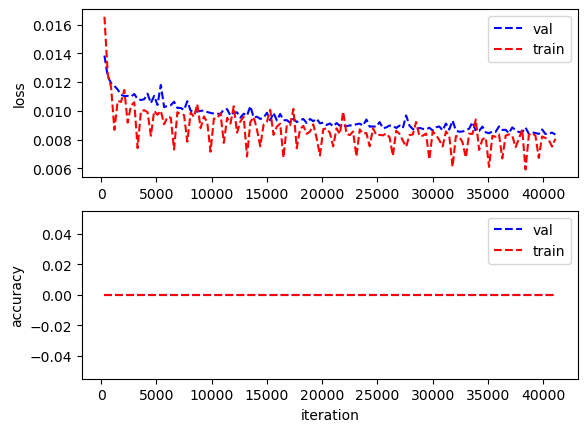

In [496]:
hp = hyperparams(ConfigEnum.MNIST)
#nn = model(hp.input_size, hp.output_size, hp.hidden_shapes, sigmoid, sigmoid_grad)
nn = model(hp.input_size, hp.output_size, hp.hidden_shapes, tanh, tanh_derivative)
val_hist = historian()
train_hist = historian()
logger = nnlogger(hp.output_log, ("Epoch", "Phase", "Iteration", "Accuracy", "Loss") )
train(nn, hp, val_hist, train_hist, logger)
test(nn, hp.ds_test, verbose=True, phase="Test")
nnplotter.view(val_hist, train_hist) #see results on plot
logger.close()